## **Import libraries**

In [1]:
import pandas as pd # Data Manupulation
import matplotlib.pyplot as plt # Plots
import seaborn as sns # Plots
import warnings # Ignore Warnings
import shap # Feature importances

In [2]:
warnings.filterwarnings("ignore") # Ignore Warnings

### **Load Data**

In [3]:
df=pd.read_csv("insurence_clearv2.csv")

###  *Split Inputs and Outputs*

In [4]:
def load_inputs_outputs():
    
    return df.drop(["charges"],axis="columns"),df.charges.values

X,y=load_inputs_outputs()

### *Split data*

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,
                                               test_size=0.33, # 33% for testing
                                               random_state=42)

In [7]:
X_train.shape[0],X_test.shape[0]

(896, 442)

#### *Data preprocessing*

**Note** Decision trees do not require normalization of their inputs; and since XGBoost is essentially an ensemble algorithm comprised of decision trees, it does not require normalization for the inputs either.

We will only perform **One Hot Encoding transformation** for categorical variable.

#### *One Hot Encoding*

<img src="https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.png">

It is used for qualitative categorical variables, for example in the image the color variable.
Where dummy variables are created according to the number of categories of the variables, a 1 is assigned where it complies with the condition and the others are filled with 0.

 Instead of just replacing the labels with random numbers it can affect the performance of the model, for this type of variables. Since we would be giving more weight to the categories that have the highest value. In addition, the One Hot Encoding transformation has the advantage at the geometric level, since there is already the same distance between the categories.

In [8]:
class Preprocessing_OHE():
    
    def __init__(self,X_data):
        self.X_data=X_data
    
    
    def binary(self):
        
        self.X_data["sex"]=self.X_data["sex"].apply(lambda x: 1 if x == "male"  else 0)
        self.X_data["smoker"]=self.X_data["smoker"].apply(lambda x: 1 if x == "yes"  else 0)
        self.X_data["medical_problem"]=self.X_data["medical_problem"].apply(lambda x: 1 if x == "severe"  else 0)
        
        return self.X_data
    
    def multinomial(self):
        
        return pd.get_dummies(self.X_data,columns=["region"])

   ### *Preprocessing Training Data*

In [9]:
X_train_preprocesing=Preprocessing_OHE(X_train)

In [10]:
X_train_ohe=X_train_preprocesing.binary()
X_train_ohe=X_train_preprocesing.multinomial()

In [11]:
X_train_ohe.head()

,age,sex,bmi,children,smoker,medical_problem,region_northeast,region_northwest,region_southeast,region_southwest
1046,18,1,48.950,0,0,0,0,0,1,0
682,55,1,32.775,0,0,0,0,1,0,0
1037,19,0,25.745,1,0,0,0,1,0,0
490,38,0,34.800,2,0,0,0,0,0,1
39,18,0,35.625,0,0,0,1,0,0,0


### *Preprocessing Testing Data*

In [12]:
X_test_preprocesing=Preprocessing_OHE(X_test)

In [13]:
X_test_ohe=X_test_preprocesing.binary()
X_test_ohe=X_test_preprocesing.multinomial()

In [14]:
X_test_ohe.head()

,age,sex,bmi,children,smoker,medical_problem,region_northeast,region_northwest,region_southeast,region_southwest
764,57,1,18.335,0,0,0,1,0,0,0
887,45,1,20.350,3,0,0,0,0,1,0
890,23,1,24.510,0,0,0,1,0,0,0
1293,19,0,32.490,0,1,1,0,1,0,0
259,24,0,27.600,0,0,1,0,0,0,1



<h1><center>XGBOOST</center></h1>

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11276-020-02428-7/MediaObjects/11276_2020_2428_Fig3_HTML.png">

It is part of the assembly algorithms. Which is a type of algorithms that uses weaker models, generally decision trees. The functioning of this model can be summed up with the following phrase: **"Unity is strength".**


Unlike its brother the random forest which is another ensemble algorithm, it will improve each estimator in such a way that each estimator becomes better than the previous one according to the learning rate.


For this particular problem, which is regression, that is, to predict values with a decimal, each estimator performs the prediction to subsequently obtain the average prediction for each estimator.

In [15]:
from xgboost import XGBRegressor

### **Explanation parameters**

* max_depth: Maximum depth of each decision tree.

* n_estimators: Number of estimators,that is base algorithms.

* learning_rate: Room for improvement for each decision tree, this parameter goes from 0 to 1.

* random_state: For example, if I want to run this algorithm again, it will give me a different result, due to the random state

#### *Creation of Model*

In [16]:
xgb_reg=XGBRegressor(max_depth=3,
                     learning_rate=0.01,
                     n_estimators=596,
                     random_state=42)

We assign the same parameters that we use to choose the ideal model.

#### *Train Model*

In [17]:
xgb_reg.fit(X_train_ohe,Y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=596, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

### *Model Evaluation*

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_squared_error

<h1><center>Mean Square Error</center></h1>

<img src="https://vitalflux.com/wp-content/uploads/2020/09/Regression-terminologies-Page-2-1024x619.png" width=400>

It is the average error between the value predicted by the model with respect to the model.


<h1><center>Cross Validation</center></h1>

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=400>

It consists of subsampling the data according to the number requested by the user. In order to obtain an average of generalization of the data.

In [19]:
class Evaluete():
    
    def __init__(self,X_data,y_true):
            

        self.X_data=X_data
        self.y_true=y_true

        self.model=xgb_reg
        self.predict=self.model.predict(self.X_data)
    
    def mse(self):
        
        return mean_squared_error(self.y_true,self.predict).flatten()

    def r2(self):
        
        return r2_score(self.y_true,self.predict).flatten()

    def cv_score(self):
        
        return cross_val_score(self.model,self.X_data,self.y_true,cv=10).mean().flatten()


### *Train Evaluation*

In [20]:
train_eval=Evaluete(X_train_ohe,Y_train)

In [21]:
mse_train=train_eval.mse()
r2_train=train_eval.r2()
cv_train=train_eval.cv_score()

### *Test Evaluation*

In [22]:
test_eval=Evaluete(X_test_ohe,Y_test)

In [23]:
mse_test=test_eval.mse()
r2_test=test_eval.r2()
cv_test=test_eval.cv_score()

### *Evaluation Dataframe*

In [24]:
features_df={"mse_train":mse_train,
         "mse_test":mse_test,
         "r2_train":r2_train,
         "r2_test":r2_test,
         "cv_train":cv_train,
         "cv_test":cv_test}

In [25]:
df_evaluate=pd.DataFrame(features_df)

In [26]:
df_evaluate

,mse_train,mse_test,r2_train,r2_test,cv_train,cv_test
0,2.351711e+06,3.023848e+06,0.983162,0.979416,0.975549,0.974433


In [27]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test_ohe)

### **Plot Importance**

In [28]:
def plot_importance():
    
    sns.set_style(style="whitegrid")
    shap.summary_plot(shap_values, X_test_ohe, plot_type="bar")
    
    return plt.show()

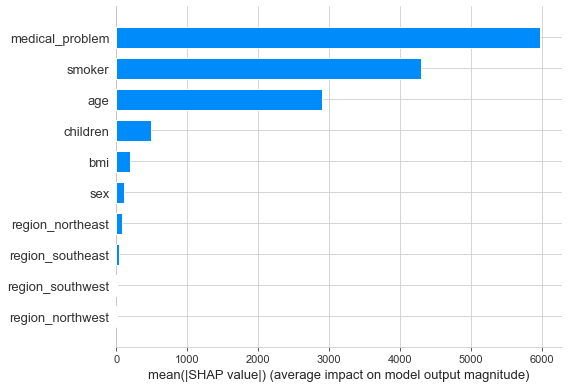

In [29]:
if __name__ == "__main__":
    plot_importance()

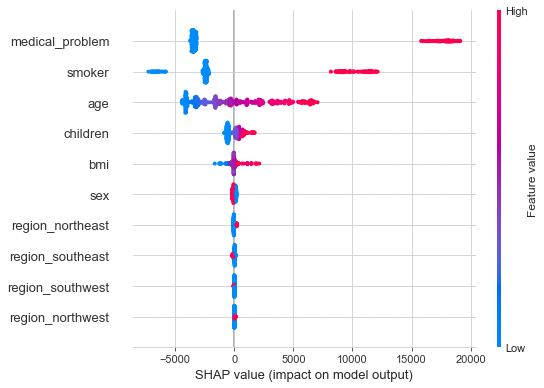

In [30]:
if __name__ == '__main__':
    
    shap.summary_plot(shap_values, X_test_ohe)

* We note that the **medical problem** variable that we created in the Featurew Engineering section. It has great weight when estimating the price of the insurance, since if we have a very serious problem, the cost of the insurance will not increase more.

* The **smoker** variable also has great weight, since people generally have a worse state of health.

* The variable **age** adds value to the predictions. Since it can be understood that elderly people require more medical care.

The other variables may not have as much relevance compared to the previous variables that I mentioned earlier. But they can complement the value of the prediction. And that the difference between humans and machines when making predictions is that we rely on only relevant variables, while machines use these variables and also those that are not so significant, since they look for patterns unknown to the naked eye .

#### **We make predictions**

In [31]:
y_pred=xgb_reg.predict(X_test_ohe)
y_pred=y_pred.flatten()

In [32]:
X_test["smoker"]=X_test["smoker"].apply(lambda x: "yes" if x ==1 else "no")

In [33]:
df_test=pd.DataFrame({"y_true":Y_test,
                      "y_pred":y_pred,
                      "smoker":X_test["smoker"]})

In [34]:
def main():
    
    fig,(ax)=plt.subplots(1,1,figsize=(20,8))
    
    ax.set_title("True Values vs Predictions")
    sns.scatterplot(data=df_test,x="y_true",y="y_pred",hue="smoker",palette="Set2")
    sns.lineplot(data=df_test,x="y_true",y="y_true",color="c")

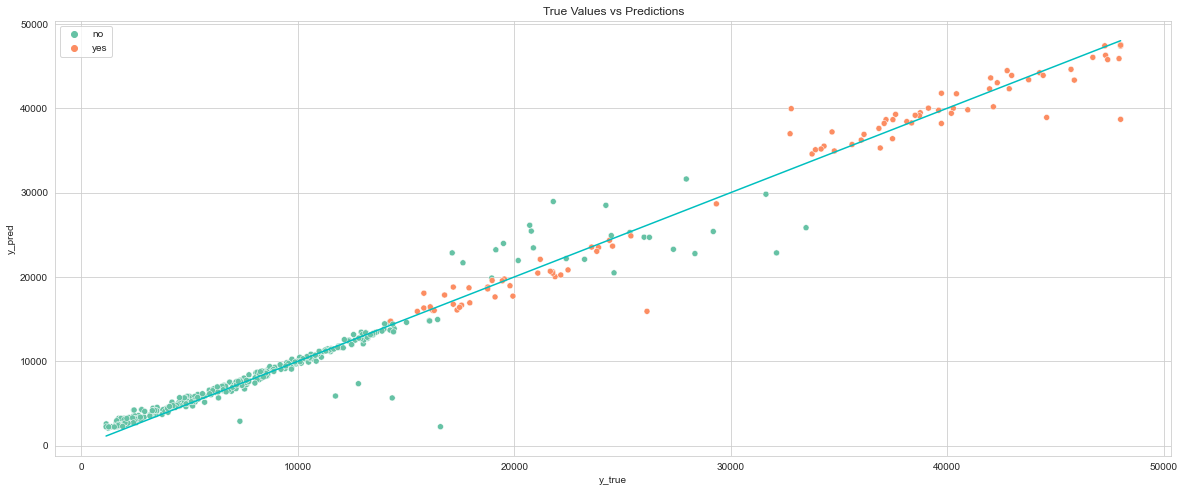

In [35]:
if __name__ == "__main__":
    
    main()

In [36]:
df_test.query("smoker=='no'").sample(n=20,random_state=42)

,y_true,y_pred,smoker
435,11538.421000,11405.943359,no
629,4350.514400,4753.903320,no
332,7323.734819,2895.726562,no
987,2699.568350,3137.377686,no
744,13470.804400,13154.744141,no
875,4561.188500,5020.006348,no
370,2201.097100,3332.743408,no
282,3180.510100,3602.754883,no
348,7345.084000,7451.192871,no
1055,22395.744240,22174.378906,no


In [37]:
df_test.query("smoker=='yes'").sample(n=20,random_state=42)

,y_true,y_pred,smoker
1302,37465.34375,36379.675781,yes
1127,17179.52200,18797.785156,yes
1235,15817.98570,16316.422852,yes
1128,42856.83800,42300.078125,yes
1293,36898.73308,35282.058594,yes
1122,33750.29180,34576.773438,yes
1242,19798.05455,18954.109375,yes
1283,33907.54800,35073.332031,yes
1228,36021.01120,36221.644531,yes
1078,34303.16720,35501.222656,yes


The algorithm generates quite robust predictions, very close to the original value. Which this model is apt to solve the problem.

As a curious fact, XGBOOST is one of the most powerful algorithms within Machine Learning, it will generate interesting results in such a short time. He is the winner of multiple competitions on the kaggle platform. It has the advantage that we can use a GPU for training, speeding up the training process, something it shares with Deep Learning frameworks.

### *Save Model*

In [38]:
xgb_reg.save_model("xgb_insurence.json")

We save the model in json format. Since its operation in production will be faster and more efficient.